# Анализ датасетов и оптимальных портфелей (Чесноков)

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Анализ иностранных бумаг
Проанализируем портфель, в котором будут акции Apple, Google и Microsoft. Попробуем решить такую задачу: найдем в каком соотношении стоит взять бумаги, чтобы минимизировать риск ликвидности. Данные за период 2013-01-02 --- 2025-11-14

## Загрузка и анализ датасета

In [2]:
def load_stock_yfinance(path) -> pd.DataFrame:
    df = pd.read_csv(path, skiprows=2)
    df.columns = ["Date", "High", "Low", "Close", "Volume"]
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.dropna(subset=["Date"])
    df[["High","Low","Close","Volume"]] = df[["High","Low","Close","Volume"]].apply(pd.to_numeric)
    df = df.set_index("Date").sort_index()

    return df

In [3]:
aapl = load_stock_yfinance("./data/individual/AAPL_20130102_20251114_yf.csv")
msft = load_stock_yfinance("./data/individual/MSFT_20130102_20251114_yf.csv")
googl = load_stock_yfinance("./data/individual/GOOGL_20130102_20251114_yf.csv")

googl.head()

,High,Low,Close,Volume
Date,,,,
2013-01-02,18.068571,17.808852,17.975368,101550348
2013-01-03,18.191098,17.912489,17.985807,92635272
2013-01-04,18.428204,18.085474,18.341217,110429460
2013-01-07,18.376262,18.157552,18.261190,66161772
2013-01-08,18.299712,18.004700,18.225151,66976956


In [4]:
msft.describe()

,High,Low,Close,Volume
count,3239.000000,3239.000000,3239.000000,3.239000e+03
mean,178.212260,174.854513,176.614341,3.029508e+07
std,145.267320,142.730024,144.047006,1.588995e+07
min,21.582571,21.203355,21.348593,7.164500e+06
25%,47.078342,46.308632,46.766586,2.081050e+07
50%,124.961187,123.506047,124.243057,2.649890e+07
75%,283.372086,277.563410,280.668045,3.490800e+07
max,554.538376,540.770020,542.070007,2.484285e+08


In [5]:
googl.describe()

,High,Low,Close,Volume
count,3239.000000,3239.000000,3239.000000,3.239000e+03
mean,81.856044,80.137600,81.024150,4.037896e+07
std,54.976683,53.705241,54.372927,2.508847e+07
min,17.530245,17.286182,17.468855,9.312000e+06
25%,37.327796,36.571015,37.014704,2.595400e+07
50%,59.858650,58.747315,59.302979,3.275200e+07
75%,122.465346,120.595990,121.633827,4.586700e+07
max,292.010010,287.320007,291.309998,4.621933e+08


In [6]:
aapl.describe()

,High,Low,Close,Volume
count,3239.000000,3239.000000,3239.000000,3.239000e+03
mean,91.773219,89.879038,90.870549,1.459968e+08
std,74.461399,72.935951,73.743405,1.205640e+08
min,12.161319,11.720028,11.885284,2.323470e+07
25%,26.361445,25.910932,26.084092,7.080535e+07
50%,51.031788,49.948906,50.322159,1.076244e+08
75%,155.759492,151.452905,153.771072,1.780573e+08
max,277.051436,272.089996,275.250000,1.460852e+09


In [7]:
prices = pd.DataFrame({
    "AAPL": aapl["Close"],
    "MSFT": msft["Close"],
    "GOOGL": googl["Close"]
}).dropna()

prices.head()

,AAPL,MSFT,GOOGL
Date,,,
2013-01-02,16.612213,22.284510,17.975368
2013-01-03,16.402525,21.985985,17.985807
2013-01-04,15.945637,21.574507,18.341217
2013-01-07,15.851845,21.534164,18.261190
2013-01-08,15.894503,21.421213,18.225151


## Подсчет доходностей

In [8]:
returns = prices.pct_change().dropna()
display(returns.head())


,AAPL,MSFT,GOOGL
Date,,,
2013-01-03,-0.012623,-0.013396,0.000581
2013-01-04,-0.027855,-0.018715,0.019761
2013-01-07,-0.005882,-0.001870,-0.004363
2013-01-08,0.002691,-0.005245,-0.001974
2013-01-09,-0.015629,0.005649,0.006573


## Ковариационная матрица доходностей

In [9]:
sigma = returns.cov().values
tickers = returns.columns
n = len(tickers)

print("Covariance matrix:")
print(sigma)

Covariance matrix:
[[0.00032052 0.00017887 0.00017139]
 [0.00017887 0.00027351 0.00018965]
 [0.00017139 0.00018965 0.00030709]]


## HL-спред

In [10]:
def compute_hl_spread(df):
    H = df["High"].values
    L = df["Low"].values

    mask = (H > 0) & (L > 0) & (H >= L)
    H = H[mask]
    L = L[mask]

    if len(H) < 3:
        return np.nan

    beta = np.mean((np.log(H / L))**2)

    H2 = np.maximum(H[1:], H[:-1])
    L2 = np.minimum(L[1:], L[:-1])
    gamma = np.mean((np.log(H2 / L2))**2)

    denom = np.sqrt(3 - 2*np.sqrt(2))
    alpha = (np.sqrt(2*beta) - np.sqrt(gamma)) / denom

    spread = (2*(np.exp(alpha) - 1)) / (1 + np.exp(alpha))

    return spread

hl_spreads = {
    "AAPL": compute_hl_spread(aapl),
    "MSFT": compute_hl_spread(msft),
    "GOOGL": compute_hl_spread(googl)
}

print("\nHL-spreads:")
for k, v in hl_spreads.items():
    print(f"{k}: {v:.6f}")

spread_array = np.array([hl_spreads[t] for t in tickers])


HL-spreads:
AAPL: -0.008106
MSFT: -0.006047
GOOGL: -0.007973


Спред получился отрицательным. Как я понял, проблема в том, что используется понятие adjusted close, которое портит данные для использования HL-спреда https://help.yahoo.com/kb/SLN28256.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAACnFZx5IW8SdyLtZkxdT9O-kUmiGTcoam3WCDY_ttpDulwAzLLUqi3ohpQTO2VnUaA2VwkVxnJ4JN8_UfUNDL4MVfv0TjdyKoeR4iFgVVbJTy9_BhCcTCK1ZRZpc0Eet_JtBrl2ssnJHer0hOOKzwnjkfTMlc4-e7ztAcJk3P7ha

Поэтому придется считать spred в следующем виде

In [11]:
def compute_spread(df):
    spread = (df["High"] - df["Low"]) / df["Close"]
    return spread.median()

spreads = {
    "AAPL": compute_spread(aapl),
    "MSFT": compute_spread(msft),
    "GOOGL": compute_spread(googl)
}

print("\nSimple spreads:")
for k, v in spreads.items():
    print(f"{k}: {v:.6f}")

spread_array = np.array([spreads[t] for t in tickers])


Simple spreads:
AAPL: 0.017146
MSFT: 0.015864
GOOGL: 0.017250


## Выбор портфеля с наименьшим риском и подсчет LVaR

In [12]:
from scipy.stats import norm

z = norm.ppf(0.95)

def portfolio_lvar(w, sigma, hl, z):
    sigma_p = np.sqrt(w @ sigma @ w)
    var = z * sigma_p
    liquidity_cost = 0.5 * (w @ hl)
    return var + liquidity_cost

w0 = np.ones(n) / n
cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1)] * n

opt_lvar = minimize( # нахождение оптимальных весов для бумаг в портфеле
    portfolio_lvar,
    w0,
    args=(sigma, spread_array, z),
    method="SLSQP",
    bounds=bounds,
    constraints=[cons]
)

w_lvar = opt_lvar.x

print("\nOptimal weights for LVaR minimization:")
for t, w in zip(tickers, w_lvar):
    print(f"{t}: {w:.4f}")


Optimal weights for LVaR minimization:
AAPL: 0.2804
MSFT: 0.4357
GOOGL: 0.2839


Таким образом, в нашем портфеле большую часть должны занимать акции Microsoft

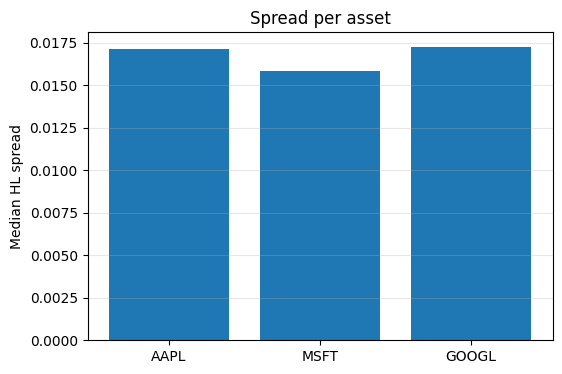

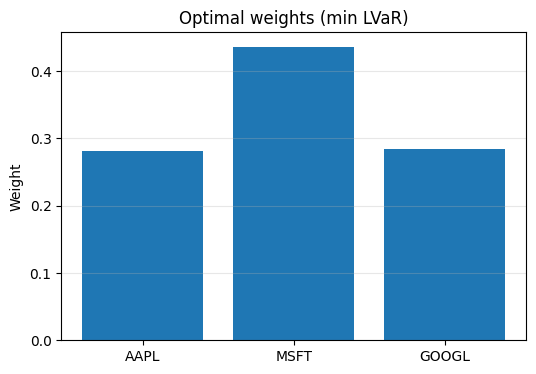

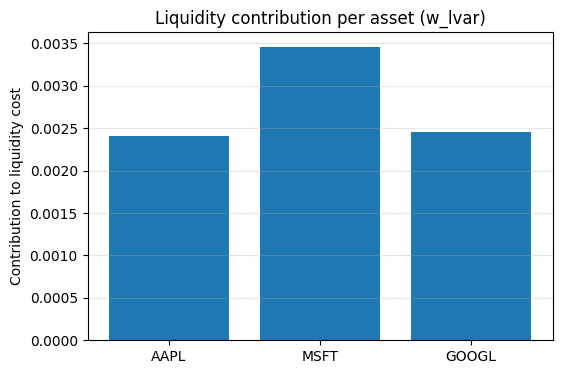

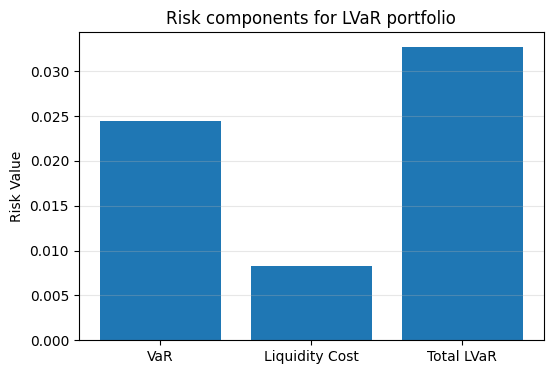

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.bar(tickers, spread_array)
plt.title("Spread per asset")
plt.ylabel("Median HL spread")
plt.grid(axis='y', alpha=0.3)
plt.show()


plt.figure(figsize=(6,4))
plt.bar(tickers, w_lvar)
plt.title("Optimal weights (min LVaR)")
plt.ylabel("Weight")
plt.grid(axis='y', alpha=0.3)
plt.show()


liq_contrib_lvar = w_lvar * 0.5 * spread_array

plt.figure(figsize=(6,4))
plt.bar(tickers, liq_contrib_lvar)
plt.title("Liquidity contribution per asset (w_lvar)")
plt.ylabel("Contribution to liquidity cost")
plt.grid(axis='y', alpha=0.3)
plt.show()


sigma_l = np.sqrt(w_lvar @ sigma @ w_lvar)
VaR_l   = z * sigma_l
liq_l   = 0.5 * (w_lvar @ spread_array)
LVaR_l  = VaR_l + liq_l

labels = ["VaR", "Liquidity Cost", "Total LVaR"]
values = [VaR_l, liq_l, LVaR_l]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("Risk components for LVaR portfolio")
plt.ylabel("Risk Value")
plt.grid(axis='y', alpha=0.3)
plt.show()


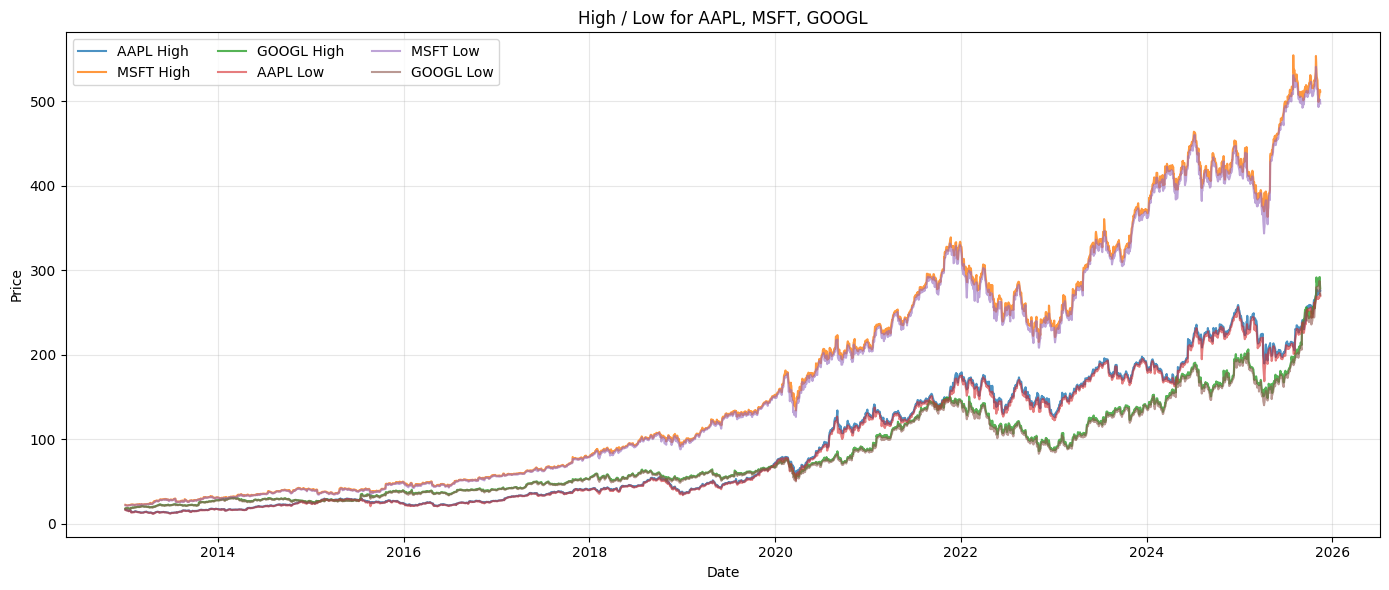

In [14]:
plt.figure(figsize=(14,6))

plt.plot(aapl.index, aapl["High"], label="AAPL High", alpha=0.8)
plt.plot(msft.index, msft["High"], label="MSFT High", alpha=0.8)
plt.plot(googl.index, googl["High"], label="GOOGL High", alpha=0.8)

plt.plot(aapl.index, aapl["Low"], label="AAPL Low", alpha=0.6)
plt.plot(msft.index, msft["Low"], label="MSFT Low", alpha=0.6)
plt.plot(googl.index, googl["Low"], label="GOOGL Low", alpha=0.6)

plt.title("High / Low for AAPL, MSFT, GOOGL")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

Как видим, Microsoft больше всех идет вверх и можно назвать ликвиднее своих конкуретнов. Но при этом все равно LVaR минимизируется путем диверсификации портфеля (то есть нет такого, что 100% портфеля должны быть Microsoft), что так же согласуется с интуицией

# Анализ российских бумаг

Проделаем аналогичные действия с российским рынком:
- Газпром
- Лукойл
- Новатэк
- Роснефть
- Сбер

Период 2023-11-20	---- 2024-01-30

In [15]:
def load_stock_moex(path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[["Date", "High", "Low", "Close", "Volume"]]

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.dropna(subset=["Date"])

    df = df[~df["Date"].duplicated(keep="last")]

    df = df.set_index("Date").sort_index()
    df = df.apply(pd.to_numeric)

    return df


In [16]:
moex_files = {
    "GAZP":  "./data/individual/GAZP_2023-11-19_2025-11-17_moex.csv",
    "LKOH":  "./data/individual/LKOH_2023-11-19_2025-11-17_moex.csv",
    "NVTK":  "./data/individual/NVTK_2023-11-19_2025-11-17_moex.csv",
    "ROSN":  "./data/individual/ROSN_2023-11-19_2025-11-17_moex.csv",
    "SBER":  "./data/individual/SBER_2023-11-19_2025-11-17_moex.csv",
}

moex_data = {ticker: load_stock_moex(path) for ticker, path in moex_files.items()}

for t, df in moex_data.items():
    print(t, df.shape)

prices = pd.DataFrame({t: df["Close"] for t, df in moex_data.items()}).dropna()
prices.head()

GAZP (50, 4)
LKOH (98, 4)
NVTK (98, 4)
ROSN (98, 4)
SBER (50, 4)


,GAZP,LKOH,NVTK,ROSN,SBER
Date,,,,,
2023-11-20,165.51,7194.5,1545.6,581.50,282.91
2023-11-21,165.15,7209.0,1539.0,583.40,282.79
2023-11-22,165.37,7299.0,1525.8,581.75,286.16
2023-11-23,164.11,7258.0,1511.2,580.80,286.19
2023-11-24,164.71,7295.0,1514.0,578.85,286.85


In [17]:
returns = prices.pct_change().dropna()
tickers = returns.columns
n = len(tickers)
sigma = returns.cov().values

In [18]:
def compute_hl_spread_cs(df):
    H = df["High"].values
    L = df["Low"].values

    mask = (H > 0) & (L > 0) & (H >= L)
    H = H[mask]
    L = L[mask]

    if len(H) < 3:
        return np.nan

    beta = np.mean((np.log(H / L))**2)

    H2 = np.maximum(H[1:], H[:-1])
    L2 = np.minimum(L[1:], L[:-1])
    gamma = np.mean((np.log(H2 / L2))**2)

    denom = np.sqrt(3 - 2*np.sqrt(2))
    alpha = (np.sqrt(2*beta) - np.sqrt(gamma)) / denom

    spread = (2*(np.exp(alpha) - 1)) / (1 + np.exp(alpha))
    return spread


In [19]:
hl_spreads = {t: compute_hl_spread_cs(df) for t, df in moex_data.items()}

print("HL-spreads:")
for t, v in hl_spreads.items():
    print(f"{t}: {v}")

hl = np.array([hl_spreads[t] for t in tickers])


HL-spreads:
GAZP: 0.004406295842181719
LKOH: -0.005403056235103602
NVTK: 9.508688338540009e-05
ROSN: -0.001696482859097285
SBER: 0.004451171606111012


Аналогично имеем отрицательные спреды

In [20]:
def compute_spread(df):
    spread = (df["High"] - df["Low"]) / df["Close"]
    return spread.median()

spreads = {t: compute_spread(df) for t, df in moex_data.items()}


print("\nSimple spreads:")
for k, v in spreads.items():
    print(f"{k}: {v:.6f}")

spread_array = np.array([spreads[t] for t in tickers])


Simple spreads:
GAZP: 0.013763
LKOH: 0.012128
NVTK: 0.018215
ROSN: 0.013359
SBER: 0.013684


In [21]:
z = norm.ppf(0.95)

def portfolio_lvar(w, sigma, spread_array, z):
    sigma_p = np.sqrt(w @ sigma @ w)
    var = z * sigma_p
    liquidity_cost = 0.5 * (w @ spread_array)
    return var + liquidity_cost

w0 = np.ones(n) / n
cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0,1)] * n

opt_lvar = minimize(portfolio_lvar,
                    w0,
                    args=(sigma, spread_array, z),
                    method="SLSQP",
                    bounds=bounds,
                    constraints=[cons])

w_lvar = opt_lvar.x


In [22]:
print("\nOptimal weights (min LVaR):")
for t, w in zip(tickers, w_lvar):
    print(f"{t}: {w:.4f}")



Optimal weights (min LVaR):
GAZP: 0.3135
LKOH: 0.4239
NVTK: 0.0109
ROSN: 0.1293
SBER: 0.1224


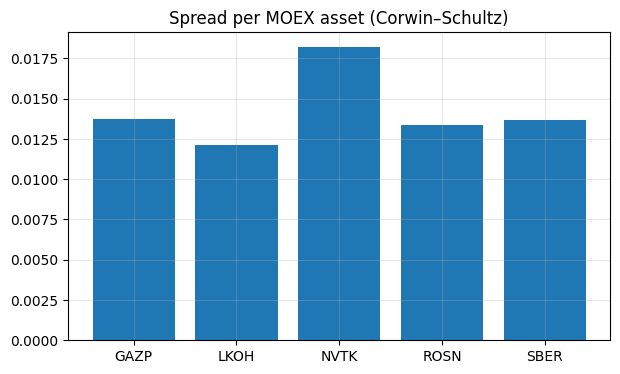

In [23]:
plt.figure(figsize=(7,4))
plt.bar(tickers, spread_array)
plt.title("Spread per MOEX asset (Corwin–Schultz)")
plt.grid(alpha=0.3)
plt.show()


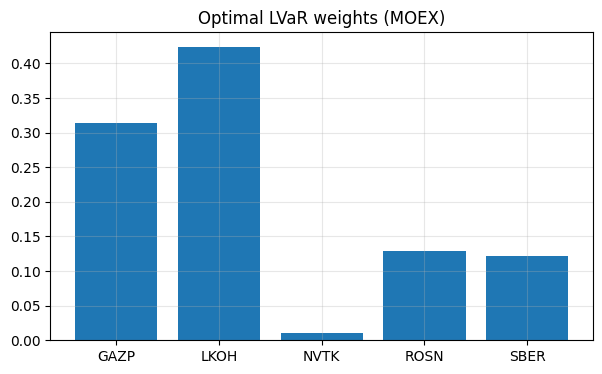

In [24]:
plt.figure(figsize=(7,4))
plt.bar(tickers, w_lvar)
plt.title("Optimal LVaR weights (MOEX)")
plt.grid(alpha=0.3)
plt.show()


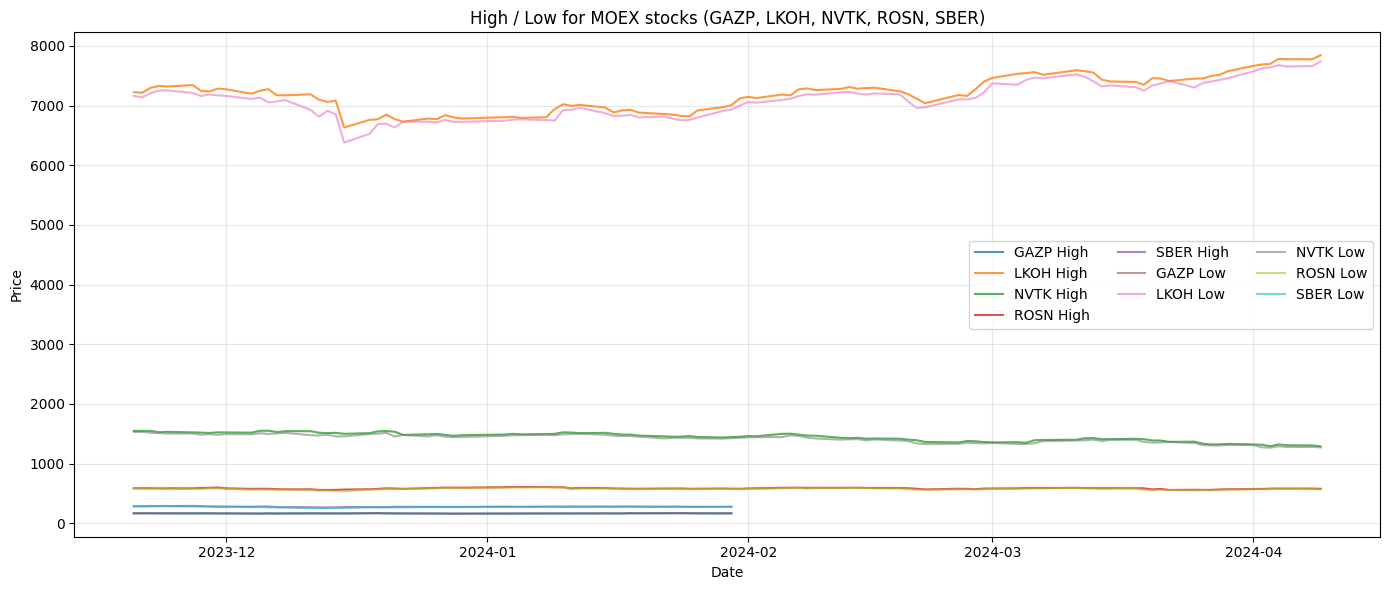

In [25]:
plt.figure(figsize=(14,6))

plt.plot(moex_data["GAZP"].index, moex_data["GAZP"]["High"], label="GAZP High", alpha=0.8)
plt.plot(moex_data["LKOH"].index, moex_data["LKOH"]["High"], label="LKOH High", alpha=0.8)
plt.plot(moex_data["NVTK"].index, moex_data["NVTK"]["High"], label="NVTK High", alpha=0.8)
plt.plot(moex_data["ROSN"].index, moex_data["ROSN"]["High"], label="ROSN High", alpha=0.8)
plt.plot(moex_data["SBER"].index, moex_data["SBER"]["High"], label="SBER High", alpha=0.8)

plt.plot(moex_data["GAZP"].index, moex_data["GAZP"]["Low"], label="GAZP Low", alpha=0.6)
plt.plot(moex_data["LKOH"].index, moex_data["LKOH"]["Low"], label="LKOH Low", alpha=0.6)
plt.plot(moex_data["NVTK"].index, moex_data["NVTK"]["Low"], label="NVTK Low", alpha=0.6)
plt.plot(moex_data["ROSN"].index, moex_data["ROSN"]["Low"], label="ROSN Low", alpha=0.6)
plt.plot(moex_data["SBER"].index, moex_data["SBER"]["Low"], label="SBER Low", alpha=0.6)

plt.title("High / Low for MOEX stocks (GAZP, LKOH, NVTK, ROSN, SBER)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.legend(ncol=3)
plt.tight_layout()
plt.show()


Таким образом, для минимизации LVaR портфеля мы должны преимущественно владеть акциями Лукойл
- GAZP: 0.3135
- LKOH: 0.4239
- NVTK: 0.0109
- ROSN: 0.1293
- SBER: 0.1224

Результаты LVaR хорошо совпадают с тем, что мы и так ожидаем: модель уменьшает долю менее ликвидных и более рискованных бумаг и увеличивает долю более стабильных. В итоге получается портфель, который выглядит логично и соответствует обычным принципам диверсификации.

Данную модель можно немного покритиковать за то, что она никак не учитывает новостной фон и в период резких событий может оказаться недостаточно гибкой